# Evaluation

# Setup

In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import time
import krippendorff
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
from sentence_transformers import SentenceTransformer

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils import get_table_from_supabase, extract_classifications
from evaluation_utils import get_recipients_by_id, format_tests

backend_path = os.path.abspath("../11_backend")
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)
from scoring_logic import *

#get keys from env
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

----

# Retrieving Data from Checkpoints

In [2]:
#get checkpoint folder
checkpoint_folder = Path("./13.1_checkpoints/")

#get checkpoint
funders_df = pd.read_pickle(checkpoint_folder / "funders_df.pkl")
grants_df = pd.read_pickle(checkpoint_folder / "grants_df.pkl")
areas_df = pd.read_pickle(checkpoint_folder / "areas_df.pkl")
hierarchies_df = pd.read_pickle(checkpoint_folder / "hierarchies_df.pkl")
eval_df = pd.read_pickle(checkpoint_folder / "eval_df.pkl")

-----

# Retrieving Data from Supabase and Building Dataframes

I have imported the evaluation pairs dataframe that was built as part of the logic development, but it is missing data for rows where `is_recipient=False`. This is due to the way that the database was built; these charities had not been linked to any grants from the 360Giving API or extracted from accounts, so did not get fed through the entire database building process. I will run the same embedding and classification extraction processes for these rows that have been used for the user preparation in prior notebooks, to ensure that the evaluation funder-recipient pairs have all data necessary to calculate their alignment scores.

In [3]:
#get data for evaluation recipients
recipient_ids = eval_df["recipient_id"].unique()
recipients_df = get_recipients_by_id(url, key, recipient_ids)

## Creation of Embeddings

In [4]:
model = SentenceTransformer("all-roberta-large-v1")
recipient_cols = ["recipient_name", "recipient_activities", "recipient_objectives"]
recipients_false = recipients_df[recipients_df["is_recipient"] == False].copy()
recipients_false["recipient_concat_em"] = None

if len(recipients_false) > 0:
    for col in recipient_cols:
        #replace nans with empty string
        texts = recipients_false[col].fillna("").tolist()
        embeddings = model.encode(texts)

        #add to df
        recipients_false[f"{col}_em"] = list(embeddings)

    recipients_false["concat_text"] = recipients_false[recipient_cols[0]].fillna("")
    for col in recipient_cols[1:]:
        recipients_false["concat_text"] += " " + recipients_false[col].fillna("")

    #make lowercase
    recipients_false["concat_text"] = recipients_false["concat_text"].str.lower()

    #create embeddings
    texts = recipients_false["concat_text"].tolist()
    embeddings = model.encode(texts)
    recipients_false["recipient_concat_em"] = list(embeddings)

    #drop concatenated text
    recipients_false = recipients_false.drop(columns=["concat_text"])

    embedding_cols = [f"{col}_em" for col in recipient_cols] + ["recipient_concat_em"]
    for col in embedding_cols:
        recipients_false.loc[recipients_false["is_recipient"] == False, col] = recipients_false[col].values

## Creation of Extracted Classes

In [5]:
#load classifications data
ukcat_url = "https://raw.githubusercontent.com/lico27/ukcat/main/data/ukcat.csv"
ukcat_df = pd.read_csv(ukcat_url)

#define elements to process
recipient_sections = ["recipient_name", "recipient_objectives", "recipient_activities"]
keyword_data = [(recipients_false, recipient_sections, "recipient")]
recipients_false["extracted_class"] = recipients_false["recipient_areas"].copy()

#extract classifications
for df, sections, name in keyword_data:
    start_time = time.time()
    df["recipient_extracted_class"] = df.apply(lambda row: extract_classifications(row, sections, ukcat_df, areas_df), axis=1)
    elapsed_time = time.time() - start_time
    print(f"Classification extraction complete for {name}. Total time: {elapsed_time:.2f}s")

Classification extraction complete for recipient. Total time: 0.27s


In [6]:
#capitalise extracted classifications
recipients_false["recipient_extracted_class"] = recipients_false["recipient_extracted_class"].apply(lambda classifications: [phrase.upper() for phrase in classifications] if isinstance(classifications, list) else [])

#remove "grant making"
recipients_false["recipient_extracted_class"] = recipients_false["recipient_extracted_class"].apply(lambda classifications: [phrase for phrase in classifications if phrase != "GRANT MAKING"] if isinstance(classifications, list) else [])

#drop extra column
recipients_false = recipients_false.drop(columns=["extracted_class"])

## The Final Evaluation Pairs Dataframe

In [7]:
#remove rows with missing data and concat recipients dfs
recipients_df = recipients_df[~recipients_df["recipient_id"].isin(recipients_false["recipient_id"])]
recipients_df = pd.concat([recipients_df, recipients_false], ignore_index=True)

#drop old recipient cols and add new to eval_df
recipient_cols = [col for col in eval_df.columns if col.startswith("recipient_") and col != "recipient_id"]
eval_df = eval_df.drop(columns=recipient_cols)
eval_df = eval_df.merge(recipients_df, on="recipient_id", how="left")
eval_df = eval_df.rename(columns=lambda col: f"user_{col[len('recipient_'):]}" if col.startswith("recipient_") else col)

In [8]:
pd.set_option("display.max_columns", None)
eval_df.head(1)

,id,funder_registered_num,user_id,name,website,activities,objectives,income_latest,expenditure_latest,objectives_activities,achievements_performance,grant_policy,is_potential_sbf,is_on_list,is_nua,name_em,activities_em,objectives_em,objectives_activities_em,achievements_performance_em,grant_policy_em,concat_em,extracted_class,causes,areas,beneficiaries,income_history,expenditure_history,list_entries,user_name,user_activities,is_recipient,user_objectives,user_name_em,user_activities_em,user_objectives_em,user_concat_em,user_extracted_class,user_areas,user_causes,user_beneficiaries
0,1,298633,1207372,BACON CHARITABLE TRUST,None,MAKING DONATIONS TO SUCH CHARITABLE INSTITUTIO...,TO APPLY THE INCOME AND ALL OR SUCH PART OR PA...,72879.0,72879.0,None,None,None,False,False,False,"[0.004460917,0.035826597,-0.01591086,-0.011070...","[-0.0064024967,0.037508424,-0.0025785645,-0.02...","[-0.024516284,0.022869943,-0.032995474,-0.0348...","[-0.019817753,-0.00571729,0.022262126,-0.03666...","[-0.019817753,-0.00571729,0.022262126,-0.03666...","[-0.019817753,-0.00571729,0.022262126,-0.03666...","[-0.021681184,0.0020920401,0.009623636,-0.0578...","[""GRANT MAKING""]","[General Charitable Purposes, Environment/cons...","[Lincolnshire, Norfolk]",[Other Charities Or Voluntary Bodies],"{2020: 23696.0, 2021: 27920.0, 2022: 242325.0,...","{2020: 23696.0, 2021: 27920.0, 2022: 242325.0,...",[],CATTON GROVE COMMUNITY CENTRE CIO,CATTON GROVE COMMUNITY CENTRE SUPPORTS A WIDE ...,False,THE OBJECTS OF THE CIO ARE TO FURTHER BENEFIT ...,"[0.006319203, 0.0067654094, -0.029557364, -0.0...","[0.0027825288, -0.043152414, 0.016655156, -0.0...","[-0.011579754, 0.0077819657, -0.030523552, -0....","[-0.02640823, 0.0003374529, 0.019409541, -0.04...","[NORFOLK, COMMUNITY ASSOCIATION, COMMUNITY DEV...",[Norfolk],[Recreation],"[Children/young People, Elderly/old People, Pe..."


## Evaluation Responses

In [9]:
#get table from supabase
responses_df = get_table_from_supabase(url, key, "evaluation_responses")

#assign ids to respondents
responses_df["respondent_id"] = (responses_df["id"] - 61) // 3 + 1

# Evaluate Inter-Rater Reliability

In [10]:
#pivot to get table and calculate k-alpha
k_alpha_table = responses_df.pivot(index="respondent_id", columns="pair_id", values="rating")
ka = krippendorff.alpha(k_alpha_table.values, level_of_measurement="interval")
print(f"Krippendorff's Alpha: {ka:.3f}")

Krippendorff's Alpha: 0.519


In [11]:
#get scores for all pairs and display
for idx, row in eval_df.iterrows():
    result_v2 = calculate_alignment_score(eval_df, idx, grants_df, areas_df, hierarchies_df, model)
    format_tests(idx, row, result_v2)

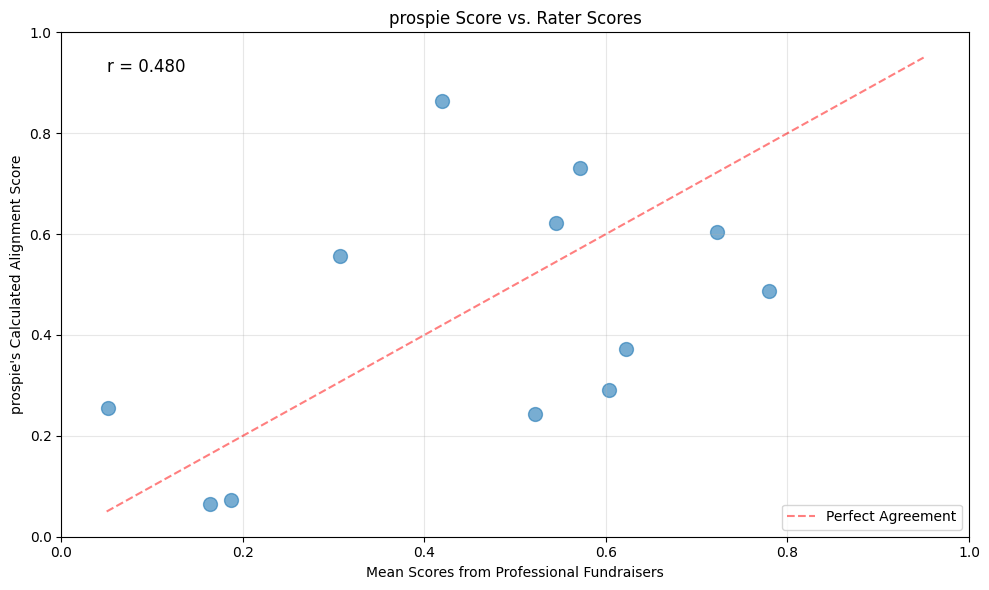

In [12]:
#store calculated scores
eval_df["calculated_score"] = eval_df.apply(
    lambda row: calculate_alignment_score(
        eval_df,
        row.name,
        grants_df,
        areas_df,
        hierarchies_df,
        model
    ),
    axis=1
)

#find mean rater scores and add to df
mean_ratings = responses_df.groupby("pair_id")["rating"].mean().reset_index()
mean_ratings.columns = ["id", "mean_rating"]
comparison_df = eval_df[["id", "calculated_score"]].merge(mean_ratings, on="id", how="inner")

#normalise mean rater scores
comparison_df["mean_rating_norm"] = ((comparison_df["mean_rating"] - 1) / 99) * 0.90 + 0.05

#create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df["mean_rating_norm"], comparison_df["calculated_score"], alpha=0.6, s=100)

#get pearsons r
corr = comparison_df["mean_rating_norm"].corr(comparison_df["calculated_score"])
plt.text(0.05, 0.95, f'r = {corr:.3f}', transform=plt.gca().transAxes,
        fontsize=12, verticalalignment="top")

#add labels
plt.xlabel("Mean Scores from Professional Fundraisers")
plt.ylabel("prospie's Calculated Alignment Score")
plt.title("prospie Score vs. Rater Scores")
plt.grid(True, alpha=0.3)

#add line
plt.plot([0.05, 0.95], [0.05, 0.95], "r--", alpha=0.5, label="Perfect Agreement")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()